# Experimental results analysis

## Imports

In [1]:
import numpy as np
from os.path import join as jn
import pickle as pkl
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('classic')

## Loading experimental results

In [2]:
DD_PATH = '/media/aria/3d8d23f2-fbab-4f49-969f-cc936ae32f731/RESULTS/IGPS_TDEP'
edh = np.genfromtxt(jn(DD_PATH, 'exp_nmr/dh.csv'), delimiter=',')
edh[edh== 0] = np.nan
indexes = np.where(~np.isnan(edh)==True)[0]
edh = edh[~np.isnan(edh)]
id2res = pkl.load(open(jn(DD_PATH, 'DICT', 'idx2res.p'), 'rb'))
#Be very careful, id2res starts at 1 and edh at 0
for elt in id2res: id2res[elt] = id2res[elt][0]+str(int(id2res[elt][1:])-1)
order = np.argsort(edh)
exp_tcoffs = pd.DataFrame({
    'donor': np.array(list(id2res.values()))[order],
    'tcoff': np.sort(edh)})
exp_tcoffs

,donor,tcoff
0,I6,-10.90
1,A199,-10.25
2,D129,-7.90
3,W155,-7.85
4,F137,-7.70
...,...,...
117,A105,0.90
118,D84,1.40
119,L62,1.70
120,D73,1.95


## Lowest shifts

I7-A221
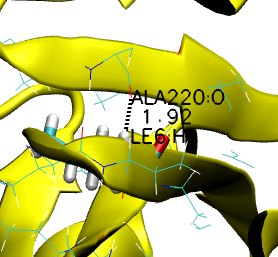
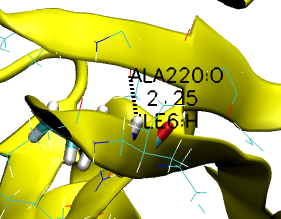
doesn't break w/ temperature. <br />
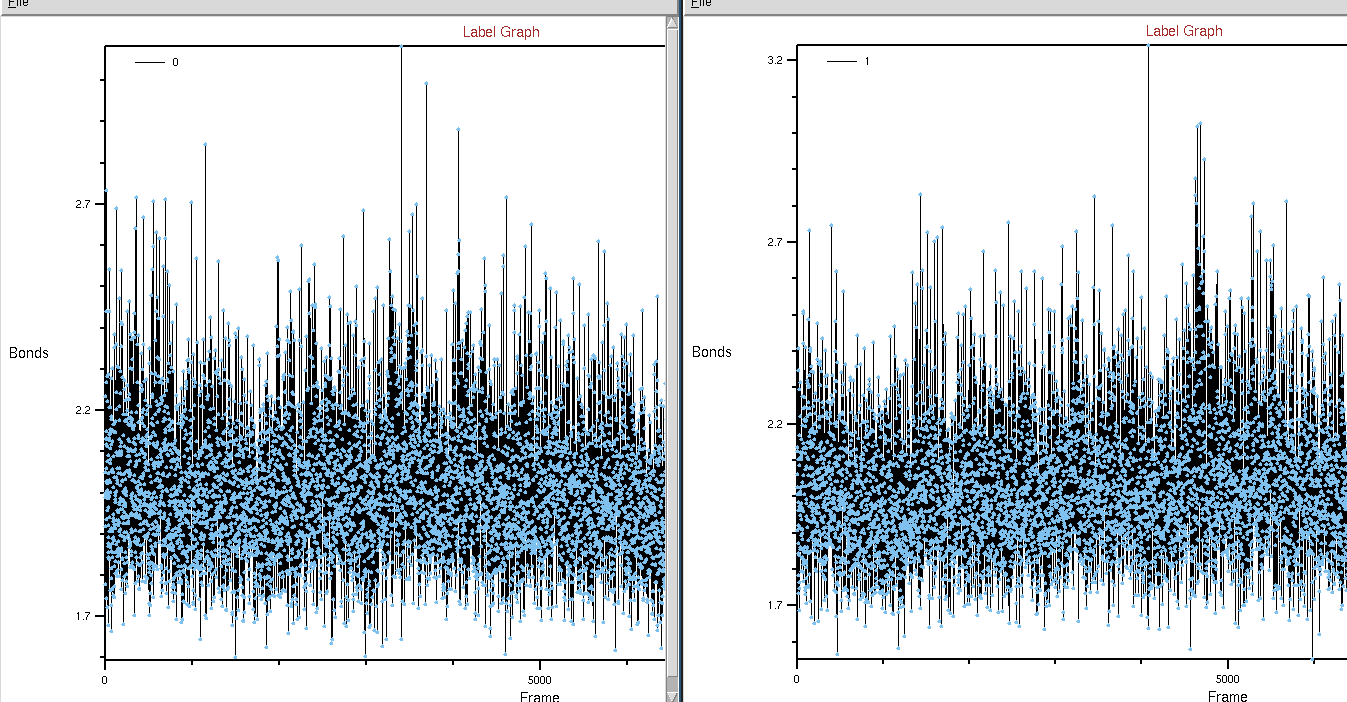

A200-A300
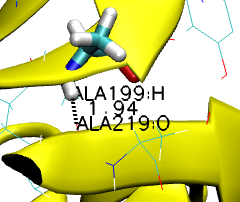
again Hbond between beta sheets, doesn't break w/ temperature <br />
D131-water(?)
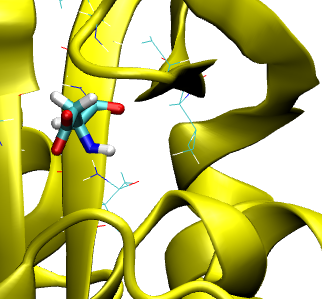
W156-L152
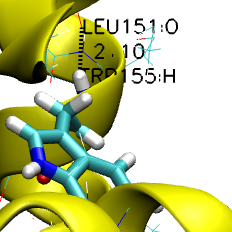
inside alpha helix <br />
F138
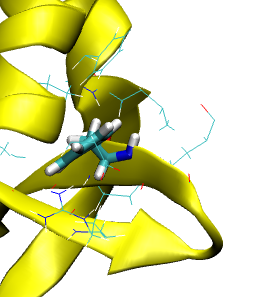
probably with water as well

## Highest shifts
V12-L49
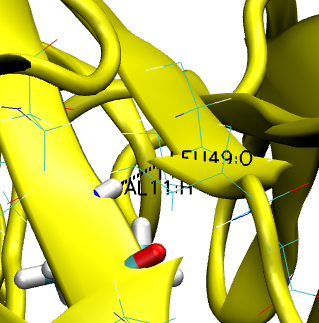
beta-sheet... I don't understand... <br />
D74 (hilighted by Pertnet analysis)
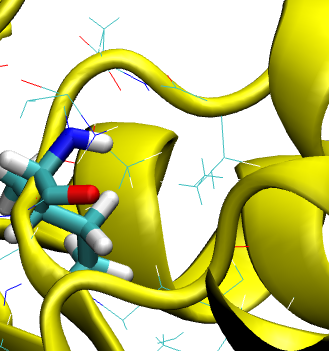
water again ? Doesn't change with respect to temperature <br />
L63
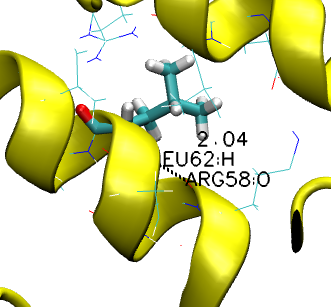
alpha-helix no change with respect to temperature <br />



In [3]:
interesting_range = exp_tcoffs.loc[(exp_tcoffs['tcoff'] <= -1) & (exp_tcoffs['tcoff'] >= -4.6)]
interesting_range

,donor,tcoff
23,R162,-4.60
24,D232,-4.55
25,V247,-4.55
26,F209,-4.45
27,V133,-4.10
...,...,...
93,G244,-1.20
94,I74,-1.20
95,G163,-1.10
96,S179,-1.05


## Inverse proportionnality between Tcoff and Hbond-length
### Loading trajectory

In [4]:
import mdtraj as md
DD = '/media/aria/3d8d23f2-fbab-4f49-969f-cc936ae32f731/'
topo = jn(DD, 'FRAMES', 'IGPS_TDEP', '30', 'frame_1.pdb')
MD_DIR = jn(DD, 'MDRUNS', 'IGPS_Tdep')
t30 = md.load(jn(MD_DIR, '30.dcd'), top=topo)

### Computing H-bonds

In [5]:
hisF_stride = t30.atom_slice(t30.topology.select('resid 0 to 252'))[::2]
hbonds = md.baker_hubbard(hisF_stride, freq=0.1, periodic=False)

In [155]:
from Bio.PDB.Polypeptide import aa1, aa3
three2one = dict(zip(aa3, aa1))

label = lambda hbond : (t30.topology.atom(hbond[1]).residue, t30.topology.atom(hbond[2]).residue)
t2o = lambda res: three2one[res[:3]]+res[3:]
t2o_off = lambda res: three2one[res[:3]]+str(int(res[3:])+1)

amide_bonds = np.array([hbond for hbond in hbonds if hisF_stride.topology.atom(hbond[1]).name=='H'])
donors = [t2o(str(label(bond)[0])) for bond in amide_bonds] 
backbone = np.array([t30.topology.atom(bond[2]).name for bond in amide_bonds]) == 'O'
da_distances = md.compute_distances(t30, amide_bonds[:,[1,2]], periodic=False)
mean_distances = np.mean(da_distances, axis=0)
std_distances = np.std(da_distances, axis=0)
df = pd.DataFrame({'donor': donors, 
                   'mean_distance': mean_distances,
                   'std_distance': std_distances, 
                   'backbone': backbone})
bonded_df = exp_tcoffs.merge(df, how='left', on='donor')
df = df.merge(exp_tcoffs, how='left', on='donor')
bonded_df['hydrogen_bonded']= ~np.isnan(bonded_df['mean_distance'].values)
typa = lambda x: 'backbone' if x==True else ('non-bonded' if np.isnan(x) else 'sidechain')
bonded_df['type'] = bonded_df['backbone'].apply(typa)

TypeError: list indices must be integers or slices, not csc_matrix

### Plot distance vs tcoff

Text(0, 0.5, 'Temperature coefficient')

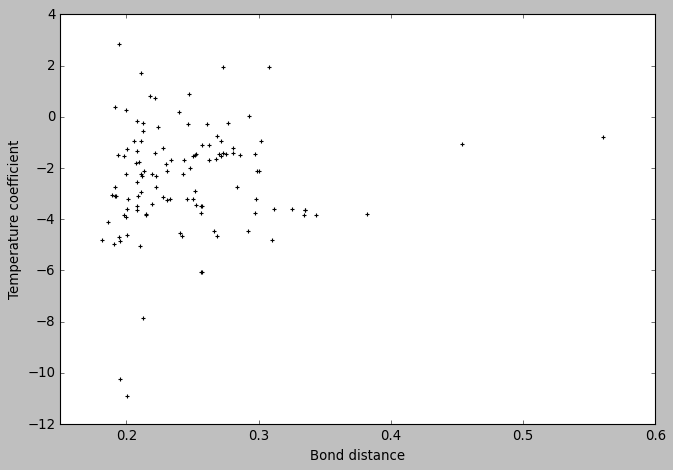

In [21]:
fig, ax = plt.subplots(1, 1, figsize = [9.6, 6.4])
ax.scatter(df['mean_distance'], df['tcoff'], marker='+', color='k')
#ax.errorbar(df['mean_distance'], df['tcoff'], xerr = df['std_distance'], ls='none')
ax.set_xlabel('Bond distance')
ax.set_ylabel('Temperature coefficient')

Text(0, 0.5, 'Temperature coefficient')

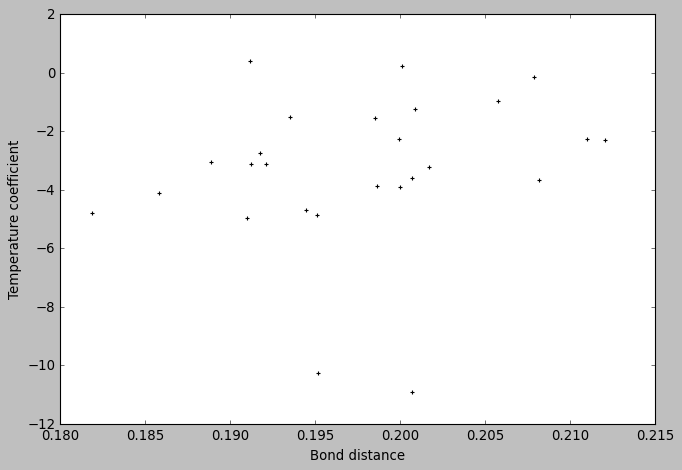

In [22]:
# Remove frames with too much incertitude
df_certain = df.loc[df['std_distance']<=0.02]
fig, ax = plt.subplots(1, 1, figsize = [9.6, 6.4])
ax.scatter(df_certain['mean_distance'], df_certain['tcoff'], marker='+', color='k')
#ax.errorbar(df_certain['mean_distance'], df_certain['tcoff'], xerr = df_certain['std_distance'], ls='none')
ax.set_xlabel('Bond distance')
ax.set_ylabel('Temperature coefficient')

### Distribution of tcoff for bonded/non-bonded amino acids

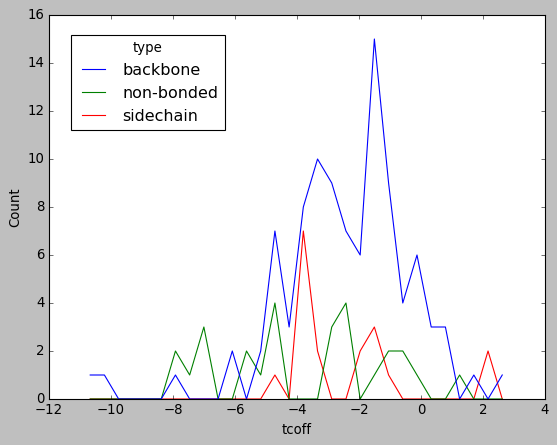

In [98]:
import seaborn as sns
sns.histplot(data=bonded_df, x='tcoff', hue='type', fill=False, element='poly', bins=30)
plt.gca().get_legend().set_bbox_to_anchor((0.37,0.97))


In conclusion here, in this system, we can't reproduce the results from the 2001 Amide proton temperature coefficient paper. Is it worth continuing?

## Correlation kabsch sander energy and tcoff

In [99]:
hisF = t30.atom_slice(t30.topology.select('resid 0 to 252'))
hbonds = md.kabsch_sander(hisF)

In [100]:
import scipy.sparse as sp

#VERY VERY naive implementation 
list_hbonds = {}
for frame in hbonds:
    id1, id2 = sp.find(frame)[:2]
#    [sum_hbonds[(u, v)] = frame[u,v]+sum_hbonds[(u, v)] if (u, v) in sum_hbonds else frame[u,v] for (u, v) in zip(id1, id2)]
    for u, v in zip(id1, id2):
        if u in list_hbonds:
            list_hbonds[u] += [frame[u,v]]
        else:
            list_hbonds[u] = [frame[u,v]]

mean_hbonds, std_hbonds = {}, {}
for donor in list_hbonds:
    mean_hbonds[donor] = np.mean(np.array(list_hbonds[donor]))
    std_hbonds[donor] = np.std(np.array(list_hbonds[donor]))

In [101]:
energies = pd.DataFrame({'donor': [t2o(str(t30.topology.residue(donor))) for donor in mean_hbonds], 
                   'mean_energy': mean_hbonds.values(),
                   'std_energy': std_hbonds.values()
                  })
energies = energies.merge(exp_tcoffs, how='left', on='donor')
energies

,donor,mean_energy,std_energy,tcoff
0,N246,-2.706196,0.525354,NaN
1,A2,-0.801298,0.243289,-5.50
2,D218,-1.490593,0.604346,NaN
3,R4,-1.433676,0.818458,-2.00
4,A220,-2.467564,0.621795,NaN
...,...,...,...,...
217,T177,-1.316998,0.628076,NaN
218,S179,-2.178912,0.818717,-1.05
219,G204,-0.523991,0.000000,NaN
220,L192,-0.501488,0.000000,-3.40


Text(0, 0.5, 'Temperature coefficient')

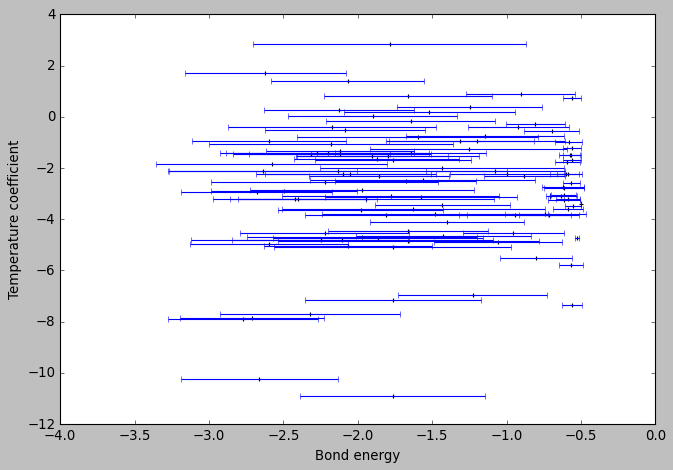

In [102]:
fig, ax = plt.subplots(1, 1, figsize = [9.6, 6.4])
ax.scatter(energies['mean_energy'], energies['tcoff'], marker='+', color='k')
ax.errorbar(energies['mean_energy'], energies['tcoff'], xerr = energies['std_energy'], ls='none')
ax.set_xlabel('Bond energy')
ax.set_ylabel('Temperature coefficient')

## Comparison between 25-35 and 35-45
### Loading data

In [115]:
shifts = pd.read_csv(jn(DD_PATH, 'exp_nmr.csv'), index_col=0)

In [178]:
dT = 10
diff2coff = lambda x: x*10**3/dT
tcoffs = pd.DataFrame({'dH-25': shifts['H-35'] - shifts['H-25'],
                       'dH-45': shifts['H-45'] - shifts['H-35']
                      })
tcoffs = tcoffs.apply(diff2coff)
tcoffs['tcoff_diff']=tcoffs['dH-45']-tcoffs['dH-25']
tcoffs['donor'] = tcoffs.index.map(lambda index: t2o_off(str(t30.topology.residue(index-1))))
tcoffs = tcoffs.sort_values('tcoff_diff')
cols = tcoffs.columns.tolist()
#Shuffling rows, there must be an easier way to do it 
tcoffs = tcoffs[[cols[-1]]+cols[:-1]] 
tcoffs

,donor,dH-25,dH-45,tcoff_diff
index,,,,
239,E239,-0.3,-9.8,-9.5
119,T119,-1.4,-10.7,-9.3
129,I129,-0.2,-9.4,-9.2
163,R163,-0.6,-8.6,-8.0
191,R191,0.8,-5.4,-6.2
...,...,...,...,...
72,Q72,-1.2,2.7,3.9
200,A200,-12.4,-8.1,4.3
12,V12,0.5,5.2,4.7


Here, a negative difference should mean a probable rupture of intramolecular hbond and a positive difference, a probable formation of intramolecular hbond

In [170]:
resid_of_interest = [41, 71, 74, 122, 161]
tcoffs_interest = tcoffs.loc[tcoffs.index.isin(resid_of_interest)]
tcoffs_interest

,donor,dH-25,dH-45,difference
index,,,,
122,S122,-7.5,-6.4,1.1
161,E161,-1.1,0.3,1.4
74,D74,1.0,2.9,1.9
41,E41,-4.6,-2.7,1.9
71,E71,-4.1,-1.6,2.5


All the involved residues have a slightly probable formation of hbond?
### Loading trajectories

In [158]:
t30 = md.load(jn(MD_DIR, '30.dcd'), top=topo)
t50 = md.load(jn(MD_DIR, '50.dcd'), top=topo)

### Getting amide proton bonds

In [173]:
def get_ap_lengths(traj, stride=10):
    hisF_stride = traj.atom_slice(traj.topology.select('resid 0 to 252'))[::stride]
    hbonds = md.baker_hubbard(hisF_stride, freq=0.1, periodic=False)
    amide_bonds = np.array([hbond for hbond in hbonds if hisF_stride.topology.atom(hbond[1]).name=='H'])
    da_distances = md.compute_distances(t30, amide_bonds[:,[1,2]], periodic=False)
    mean_distances = np.mean(da_distances, axis=0)
    donors = [t2o_off(str(label(bond)[0])) for bond in amide_bonds] 
    df = pd.DataFrame({'donor': donors, 'mean_distance': mean_distances})
    return df

ap_lengths30 = get_ap_lengths(t30)
ap_lengths50 = get_ap_lengths(t50)

In [179]:
ap_lengths = ap_lengths30.merge(ap_lengths50, on='donor')
ap_lengths['length_diff'] = ap_lenghts['mean_distance_y'] - ap_lenghts['mean_distance_x']
ap_lengths.sort_values('length_diff')
correlation = ap_lengths.merge(tcoffs, how='inner', on='donor')
correlation

,donor,mean_distance_x,mean_distance_y,length_diff,dH-25,dH-45,tcoff_diff
0,R5,0.248487,0.248487,0.000000,-2.8,-1.2,1.6
1,I7,0.200681,0.200681,0.000000,-10.9,-10.9,0.0
2,V12,0.194193,0.194193,0.000000,0.5,5.2,4.7
3,K13,0.191181,0.191181,0.000000,0.1,0.7,0.6
4,R16,0.230093,0.230093,0.000000,-2.4,-1.3,1.1
...,...,...,...,...,...,...,...
156,G245,0.280384,0.228021,-0.052363,-1.9,-0.5,1.4
157,G245,0.228021,0.280384,0.052363,-1.9,-0.5,1.4
158,G245,0.228021,0.228021,0.000000,-1.9,-0.5,1.4
159,V246,0.207887,0.207887,0.000000,0.9,-1.2,-2.1


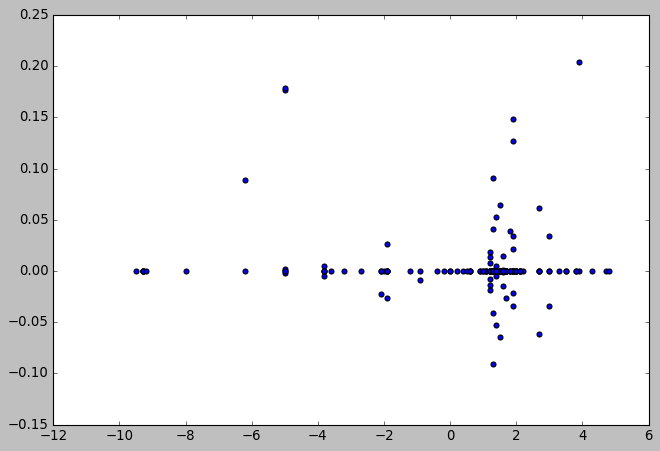

In [180]:
fig, ax = plt.subplots(1, 1, figsize=[9.6, 6.4])
ax.scatter(correlation['tcoff_diff'], correlation['length_diff'], marker=)